In [32]:
### Imports

from numpy import *
from numpy.random import *
import numpy as np
import numpy.linalg as npl
import Bio.PDB as PDB

# Kronecker product, needed to calculate Matrix Normal pdf
from theano.tensor.slinalg import kron as kron_product


In [33]:
### Defining helper functions

def sph_rand(n=3):
    """
    Return a random vector on the n-dimensional sphere S.
    """
    # Simply generate n gaussian numbers and normalize
    # From Knuth's book
    a=zeros(n, 'd')
    for i in range(0,n):
        a[i]=normal(0,1)
    return a/sqrt(sum(a*a))


def random_rotation():
    """
    Generate a random 3D rotation matrix.
    
    Requires the function sph_rand
    
    Adapted from L. Devroye, Non-Uniform Random Variate Generation (page 607,
    available online at U{http://www-cgrl.cs.mcgill.ca/~luc/rnbookindex.html}),
    by setting s=1 to avoid generating roto-inversions.
    """

    # Random rotation around z
    x,y=sph_rand(2)
    rz=array(((x,-y,0), (y, x, 0), (0,0,1)), 'd')
    
    # Random rotation around y
    x,y=sph_rand(2)
    ry=array(((x,0,y), (0,1,0), (-y, 0, x)), 'd')
    
    # Random rotation around x
    x,y=sph_rand(2)
    rx=array(((1,0,0), (0,x,y), (0, -y, x)), 'd')
    
    # Combine the three and return
    rnd_rot = rz @ ry @ rx
    return rnd_rot


def to_origin(M):
    """
    Accepts a matrix and moves it to the origin
    """
    #sum the vectors (rows)
    sum_vectors = sum(M,0)
    
    #compute the center of mass, sum of vectors divided by number of vectors
    com = sum_vectors/M.shape[0]

    #move onto origin
    M_at_o = M-com
    
    return M_at_o


def is_orthogonal(RM):
    """
    Returns boolean T/F if matrix is orthogonal or not (M.t = M^-1 in orthogonal matricies)
    """
    #transpose
    a = RM.T

    #inverse
    b = npl.inv(RM)
    
    #Checks the differnce element wise is < 0.01
    #boolean, does transpose ~= inverse (a=b element wise?)
    c = np.allclose(a,b, atol=0.01)
    print("and orthogonality is...")
    print(c)
    return

In [34]:
### Biopython 

#REQUIRES PROTEIN FILE IN SAME LOCAL DIRECTORY AS THIS SCRIPT

parser = PDB.PDBParser(QUIET=True)
structure = parser.get_structure("1ENH", "1enh.pdb")

CA_coordlist = [] #empty list to accept co-ordinates

for model in structure:
    for chain in model:
        for residue in chain:
                try:
                    CA_coordlist.append(residue['CA'].get_coord()) #creates a list of lists containing all residue atom coordinates4
                except:
                    pass


#Vertical stack to concatenate list of lists of coordinates into np array
CA_coordarray = np.vstack(CA_coordlist)

# print(type(CA_coordarray))
# print(CA_coordarray)

In [35]:
### Pre-model input calculations

N = 10 #Constant, number of desired rows/residues, must not exceed the total number of residues in the polypeptide

## Generating Average structure (Mu)

Mu = CA_coordarray[0:N,:] #Mu becomes frist N residues of parsed protein

## old toy-data method
# Mu=100*randn(N,3)
# *100 is scaling so noise has only minor effect (as intended)

print("TRUE MEAN STRUCTURE")
print(Mu)


### making the random roation matrix
rot2 = random_rotation() #making the rotaition
rot2_d = npl.det(rot2) #calculation of the determinant

print("ROTATION on T2:")
print(rot2)
print("The determinant is...")
print (rot2_d)
is_orthogonal(rot2) # is this an orthogonal matrix? (boolean)

### making the random translations
trans1 = randn(1,3)
trans2 = randn(1,3)

### creating the two 'true' structures, where each structure is a perturbation of Mu.
# no rotation is applied to the first, it is fixed to being close to the mean.
Mu_to_o = to_origin(Mu)

T_struct1 = Mu_to_o
T_struct2 = dot(Mu_to_o,rot2)

### Translating to origin
T_struct1_to_o = to_origin(T_struct1)
T_struct2_to_o = to_origin(T_struct2)

#Adding random translations and noise.
T_struct1_T = T_struct1_to_o + trans1 # adding the translation Im not sure if this is correct, should be multiplying?
input_struct1 = T_struct1_T  + normal(0,0.1,(N,3)) # adding noise

T_struct2_T = T_struct2_to_o + trans2 # adding the translation
input_struct2 = T_struct2_T + normal(0,0.1,(N,3)) # adding noise

#printing the final structures, ready for inout ot the model (Mu is not input).
print("translated Mu")
print(Mu_to_o)

print("obs STRUCTURE 1 (close to mean)")
print(input_struct1)

print("obs STRUCTURE 2")
print(input_struct2)

# # Flatten matricies, for easier calculations later
# Mu_f=array(Mu.flat)
input_struct1_f=array(input_struct1.flat)
input_struct2_f=array(input_struct2.flat)

TRUE MEAN STRUCTURE
[[  3.22000003  44.9679985   51.87099838]
 [  0.60100001  47.32600021  50.34899902]
 [ -0.87599999  46.15499878  47.07300186]
 [  0.72899997  47.48500061  43.90200043]
 [ -1.23800004  48.8429985   40.92499924]
 [ -1.93700004  46.19800186  38.31700134]
 [ -2.12899995  46.94200134  34.65599823]
 [ -5.23699999  46.23600006  32.54899979]
 [ -3.38700008  43.45800018  30.86000061]
 [ -2.14100003  42.02299881  34.15299988]]
ROTATION on T2:
[[ 0.09770129  0.23135399  0.96795133]
 [ 0.68018612  0.69447046 -0.23464359]
 [-0.72649934  0.68131205 -0.08951311]]
The determinant is...
1.0
and orthogonality is...
True
translated Mu
[[  4.45949984e+00  -9.95403290e-01   1.14054947e+01]
 [  1.84049988e+00   1.36259842e+00   9.88349533e+00]
 [  3.63499939e-01   1.91596985e-01   6.60749817e+00]
 [  1.96849990e+00   1.52159882e+00   3.43649673e+00]
 [  1.49989128e-03   2.87959671e+00   4.59495544e-01]
 [ -6.97500110e-01   2.34600067e-01  -2.14850235e+00]
 [ -8.89500022e-01   9.78599548e

In [1]:
###Theano model definition

# Imports for theano - THESE MUST BE SEPARATE from above.
import numpy as np
import numpy.random as npr
import numpy.linalg as npl
import pymc3
from pymc3 import *
from pymc3.math import *
import theano.tensor as TT
import theano as T
from theano import function
from theano import pp
# Kronecker product, needed to calculate Matrix Normal pdf
from theano.tensor.slinalg import kron as kron_product

# Here we define the Theano model we will call later.
with Model() as model:
    
    ### Defining functions for the  model
         
    def make_rotation(i):
        """
        Determines quaternions from a unifrom prior and forms from them; a rotation matrix.
        Prior over the rotation is included within
        """
        ### Rotation prior
        #uniform prior used so as to not draw prefernce to one particualr parameter
        #this is the continuous , uniform, log-liklihood
        
        # the first argument states that i will be the name of the rotation made
        xr = Uniform('x'+str(i), 0, 1, testval=0.5, shape=3) # Note shape is 3-Dimensional
        
        #Background for this is in the paper provided
        theta1 = 2*np.pi*xr[1]
        theta2 = 2*np.pi*xr[2]
        
        r1 = TT.sqrt(1-xr[0])
        r2 = TT.sqrt(xr[0])

        # Difficult to check the quaternion length is 1 (unit quaternion) - difficult
        qx = TT.cos(theta2)*r2
        qy = TT.sin(theta1)*r1
        qz = TT.cos(theta1)*r1
        qw = TT.sin(theta2)*r2        
    
        ###The rotation matrix from the quaternions
        
        # initializes a matrix (here 3x3) with 1's on the diagonal
        R = T.shared(np.eye(3))
    
        #filling the rotation matrix
        # https://www.flipcode.com/documents/matrfaq.html#Q54
        # Row one
        R = TT.set_subtensor(R[0,0], 1-(2*TT.sqr(qy))-(2*TT.sqr(qz))) 
        R = TT.set_subtensor(R[0,1], (2*(qx*qy))-(2*(qz*qw))) 
        R = TT.set_subtensor(R[0,2], (2*(qx*qz))+(2*(qy*qw))) 
        # Row two
        R = TT.set_subtensor(R[1,0], (2*(qx*qy))+(2*(qz*qw))) 
        R = TT.set_subtensor(R[1,1], 1-(2*TT.sqr(qx))-(2*TT.sqr(qz))) 
        R = TT.set_subtensor(R[1,2], (2*(qy*qz))-(2*(qx*qw))) 
        # Row three
        R = TT.set_subtensor(R[2,0], (2*(qx*qz))-(2*(qy*qw))) 
        R = TT.set_subtensor(R[2,1], (2*(qy*qz))+(2*(qx*qw))) 
        R = TT.set_subtensor(R[2,2], 1-(2*TT.sqr(qx))-(2*TT.sqr(qy))) 
        return R
    
    ### GAUSSIAN WALK for Mu
    # Proposal for a prior over Ca trace space
    mu_u=Uniform('mu_u', 0, 1, shape=N)
    mu_v=Uniform('mu_v', 0, 1, shape=N)
    
    theta_mu = 2*np.pi*mu_v
    
    phi_mu = tt.arccos(1-2*mu_u)
    
    mu_x = tt.sin(phi_mu) * tt.cos(theta_mu)
    mu_y = tt.sin(phi_mu) * tt.sin(theta_mu)
    mu_z = tt.cos(phi_mu);
    
    mu_stack = tt.stack([mu_x, mu_y, mu_z], 1)

    # Turn unit vectors into vectors of length 3.8 (standard Ca-Ca stick)
    mu_ca_stack = 3.8*mu_stack

    # Cumulative sum of unit vectors along rows 
    # (ie. we get a Ca trace)
    mu_cumsum = tt.extra_ops.cumsum(mu_ca_stack, axis=0)

    # Move center of mass to (0,0,0)
    mean_structure = mu_cumsum-tt.mean(mu_cumsum, axis=0)
    
    #print initial output?
    mean_structure_print = tt.printing.Print('mean_structure')(mean_structure)

    
    #### NOISE NEGATION
    
    ## Generating the standard covariance matrix
    # makes triangular covariance matrix, of dimension N.
    packed_L = LKJCholeskyCov('packed_L', n=N, eta=2., sd_dist=HalfCauchy.dist(0.05)) #0.05 for each seems the sweet spot for N = 10
    
    
#     packed_L_print = tt.printing.Print('packed_L')(packed_L)
    
    # Convert a packed triangular matrix into a two dimensional array.
    L = expand_packed_triangular(N, packed_L)
    
    U = L.dot(L.T)

    sv=HalfNormal("sv1", sd=1) #should be normal?
    V=sv*TT.eye(3)
    
    # See https://en.wikipedia.org/wiki/Matrix_normal_distribution#Definition
    #this is the covariance matrix between the two structures
    VU=kron_product(V,U) #should these be multiplied by V'? 
    
    ### ROTATION
    r2 = Deterministic('r2',make_rotation("rTwo"))
    
    ### TRANSLATIONS
    translation_on_1 = Normal('trans1', mu=0, sd=1, shape=(3))
    translation_on_2 = Normal('trans2', mu=0, sd=1, shape=(3))
    
    trans1_print = tt.printing.Print('trans1')(translation_on_1)
    trans2_print = tt.printing.Print('trans2')(translation_on_2)

    ### FORMING THE STRUCTURES
    #predicted mean observed structure for the two structures to be superpositioned??
    observed_struct1 = mean_structure + translation_on_1
                           
    observed_struct2_initial = TT.dot(mean_structure, r2)
    observed_struct2 = observed_struct2_initial + translation_on_2

    ### Flattening for computation
    observed_struct1_f = TT.flatten(observed_struct1) 
    observed_struct2_f = TT.flatten(observed_struct2)    
    
    ### MAP of rotation, translation and Mu
    ## this is the liklihood function
    x_obs = MvNormal("x_obs", mu=observed_struct1_f, cov=VU, observed=input_struct1_f)
    y_obs = MvNormal("y_obs", mu=observed_struct2_f, cov=VU, observed=input_struct2_f)

    ### Setting some of the final values to be in the trace and thus printable
    Mu = Deterministic('gMu', mean_structure)

NameError: name 'N' is not defined

In [37]:
### Calling Theano the model & processing outputs
map_estimate = find_MAP(maxeval=10000, model=model) # ML estimarion (liklihood x prior ) mind max

#print("THIS IS THE MAP ESTIMATE")
# print(map_estimate)

logp = 179.85, ||grad|| = 292.7: 100%|██████████| 7758/7758 [00:16<00:00, 473.46it/s]      


In [38]:
### Assigning variables from the MAP estimate

estimated_Mu = map_estimate['gMu']

t1 = map_estimate['trans1']
t2 = map_estimate['trans2']

r2 = map_estimate['r2'] 

r2_d = npl.det(r2) 

In [39]:
###Comparisons
print('\n',"Comparing translations")
#first translation on input
print('Real t1')
print(trans1)
#MAP of first translation
print("Estimated t1")
print(t1)
#Second translation on input
print("Real t2")
print(trans2)
#MAP of second translation
print("estimated t2")
print(t2)

##Rotation Estimation
print('\n',"Comparing rotations")
#the rotation on input
print("Real r2")
print(rot2)
# the MAP of the rotation
print("Estimated r2")
print(r2)
print("The determinant is...")
print(r2_d)
is_orthogonal(r2)

###Guess at true structure
print('\n',"Comparing mean structures")
#the mean actaully input to the model
print("translated MEAN STRUCTURE")
print(Mu_to_o)
#the models MAP of the mean
print("estimation of mean")
print(estimated_Mu)



 Comparing translations
Real t1
[[ 0.58640743  0.16141172  2.07616836]]
Estimated t1
[ 0.46544284 -0.0794687   2.10598495]
Real t2
[[-0.07535146  1.07558708  0.40005284]]
estimated t2
[-0.00735371  1.11250184  0.38159316]

 Comparing rotations
Real r2
[[ 0.09770129  0.23135399  0.96795133]
 [ 0.68018612  0.69447046 -0.23464359]
 [-0.72649934  0.68131205 -0.08951311]]
Estimated r2
[[-0.09350827  0.12768885  0.98739646]
 [ 0.70882947  0.70497017 -0.02403838]
 [-0.69915448  0.69764792 -0.15643016]]
The determinant is...
1.0
and orthogonality is...
True

 Comparing mean structures
translated MEAN STRUCTURE
[[  4.45949984e+00  -9.95403290e-01   1.14054947e+01]
 [  1.84049988e+00   1.36259842e+00   9.88349533e+00]
 [  3.63499939e-01   1.91596985e-01   6.60749817e+00]
 [  1.96849990e+00   1.52159882e+00   3.43649673e+00]
 [  1.49989128e-03   2.87959671e+00   4.59495544e-01]
 [ -6.97500110e-01   2.34600067e-01  -2.14850235e+00]
 [ -8.89500022e-01   9.78599548e-01  -5.80950546e+00]
 [ -3.99749

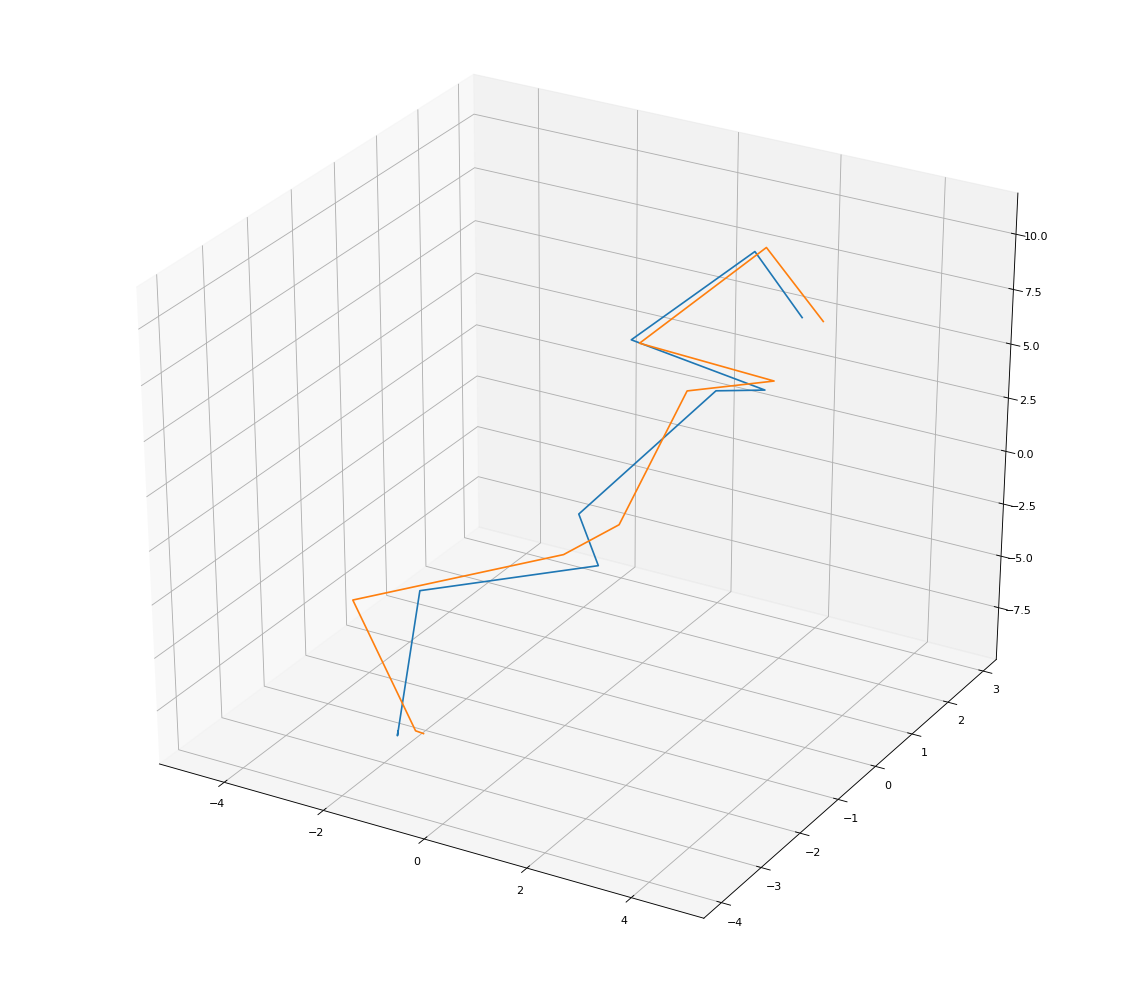

In [40]:
###Making plots
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(18, 16), dpi= 80)
ax = fig.add_subplot(111, projection='3d')
x=Mu_to_o[:,0]
y=Mu_to_o[:,1]
z=Mu_to_o[:,2]
plt.plot(x, y, z)

x2=estimated_Mu[:,0]
y2=estimated_Mu[:,1]
z2=estimated_Mu[:,2]
plt.plot(x2, y2, z2)
plt.show()


In [41]:
###RMSD as measure of difference between our estmation and the true structure
#applisno further translation or rotation
import rmsd as rmsd

rmsd.kabsch_rmsd(Mu_to_o, estimated_Mu) 

0.41466926930081688